In [1]:
from LegoRL import *

In [2]:
import gym
def make_env():
    def _thunk():
        env = gym.make('CartPole-v0').unwrapped
        return env
    return _thunk

In [3]:
import torch.nn as nn
CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 20),
                nn.ReLU(),
                nn.Linear(20, output_size),
                nn.ReLU()
)

# Advantage Actor Critic

In [4]:
agent = Composed(
    visualizer   = Visualizer(),
    runner       = Runner(policy="policy", threads=8),
    rollout      = RolloutCollector(runner="runner", rollout_length=5),
    backbone     = Backbone(CartpoleNN, embedding_size=20),
    policy       = PolicyHead(backbone="backbone"),
    critic       = ValueHead(backbone="backbone"),
    maxtrace     = MaxTrace(evaluator="critic", baseline="critic"),
    actor_loss   = ActorLoss(sampler="rollout", policy="policy", target="maxtrace"),
    critic_loss  = CriticLoss(sampler="rollout", critic="critic", target="maxtrace"),
    entropy_loss = EntropyLoss(sampler="rollout", policy="policy"),
    trainer      = Trainer(transformations=["backbone", "policy", "critic"], 
                           losses=["actor_loss", "critic_loss", "entropy_loss"], 
                           weights=[1, 0.5, 0.1])
)

In [5]:
system = System(agent, make_env=make_env)

runner: environment initialization... Finished.
Initializing <backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <policy>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])
Initializing <critic>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([])


In [6]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 8 parallel environments each 1 iteration using <policy>
<rollout>: Collects rollouts of length 5 from <runner>
<backbone>: Feature extractor network
<policy>: Head, connected to <backbone>, modeling Policy
<critic>: Head, connected to <backbone>, modeling V
<maxtrace>: Estimates maxtrace returns using <critic> to evaluate last state and <critic> as baseline
<actor_loss>: Calculates gradient estimation for <policy> using advantages from <maxtrace> and rollouts from <rollout>
<critic_loss>: Calculates TD loss for <critic> using <maxtrace> as target calculator and data from <rollout>
<entropy_loss>: Calculates entropy penalty for <policy> using rollouts from <rollout>
<trainer>: Trains <backbone>, <policy>, <critic> using following losses: <actor_loss>, <critic_loss>, <entropy_loss>

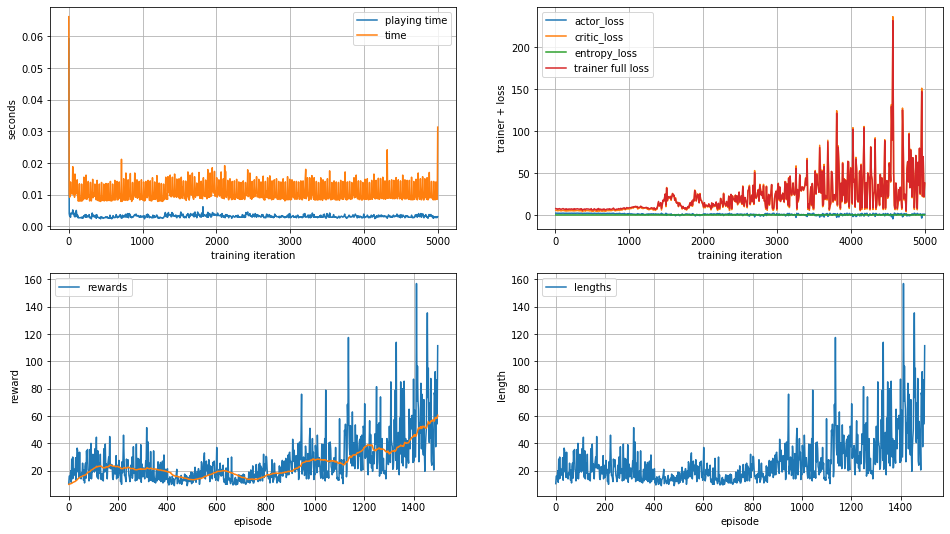

In [7]:
system.run(5000)

In [8]:
agent.runner.fps

768.7570384672784

# QAC

Actor-Critic where critic is trained via Q-learning. Yep.

In [9]:
DQN = lambda runner: Composed(
    replay          = ReplayBuffer(runner=runner),
    sampler         = Sampler(replay="replay"),
    backbone        = Backbone(CartpoleNN, embedding_size=20),
    q_head          = QualityHead(backbone="backbone"),
    target          = OneStep(evaluator="frozen_head"),
    loss            = CriticLoss(sampler="sampler", critic="q_head", target="target"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_head     = Frozen(QualityHead)(backbone="frozen_backbone", source="q_head"),
    trainer         = Trainer(transformations=["backbone", "q_head"], losses=["loss"]),
)

In [10]:
A2C = lambda runner, critic: Composed(
    rollout      = RolloutCollector(runner=runner, rollout_length=5),
    backbone     = Backbone(CartpoleNN, embedding_size=20),
    policy       = PolicyHead(backbone="backbone"),
    maxtrace     = MaxTrace(evaluator=critic, baseline=critic),
    actor_loss   = ActorLoss(sampler="rollout", policy="policy", target="maxtrace"),
    entropy_loss = EntropyLoss(sampler="rollout", policy="policy"),
    trainer      = Trainer(transformations=["backbone", "policy"], losses=["actor_loss", "entropy_loss"], weights=[1, 0.1])
)

In [11]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="A2C.policy", threads=8),
    A2C        = A2C(runner="runner", critic="DQN.q_head"),
    DQN        = DQN(runner="runner"),
    a2c_player = Player(policy="A2C.policy", timer=100),
    dqn_player = Player(policy="DQN.q_head", timer=100),
)

In [12]:
system = System(agent, make_env=make_env)

runner: environment initialization... Finished.
Initializing <A2C.backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <A2C.policy>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])
Initializing <DQN.backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <DQN.q_head>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])


In [13]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 8 parallel environments each 1 iteration using <A2C.policy>
<A2C>:
    <rollout>: Collects rollouts of length 5 from <runner>
    <backbone>: Feature extractor network
    <policy>: Head, connected to <A2C.backbone>, modeling Policy
    <maxtrace>: Estimates maxtrace returns using <DQN.q_head> to evaluate last state and <DQN.q_head> as baseline
    <actor_loss>: Calculates gradient estimation for <A2C.policy> using advantages from <A2C.maxtrace> and rollouts from <A2C.rollout>
    <entropy_loss>: Calculates entropy penalty for <A2C.policy> using rollouts from <A2C.rollout>
    <trainer>: Trains <A2C.backbone>, <A2C.policy> using following losses: <A2C.actor_loss>, <A2C.entropy_loss>
    
<DQN>:
    <replay>: Stores observations from <runner>
    <sampler>: Samples mini-batches from <DQN.replay>
    <backbone>: Feature extractor network
    <q_head>: Head, connected to <DQN.backbone>, modeling Quality
    <target>:

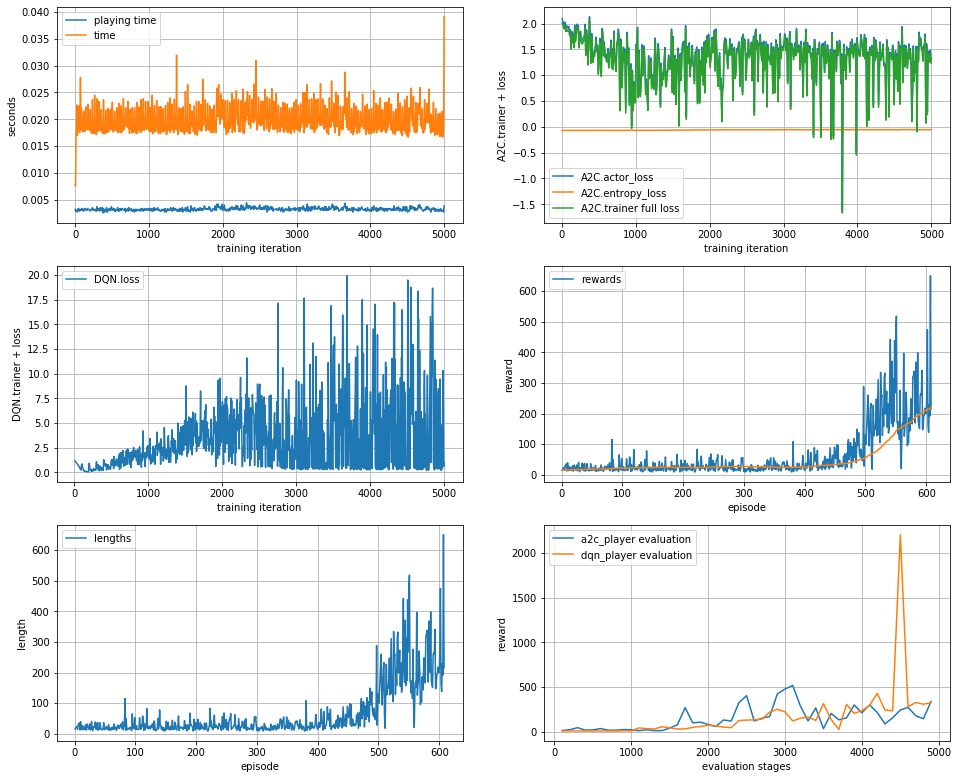

In [14]:
system.run(5000)